In [1]:
import pandas as pd
import requests_cache
import requests
from datetime import datetime, timedelta
import mplfinance as mpf
import configparser

# ignore warning
import warnings
warnings.filterwarnings("ignore")

#my free key
requests_cache.install_cache('mycache')

In [10]:
def get_api_key(config_file='config.ini', section='api', key='key'):
    config = configparser.ConfigParser()

    # Read the configuration file
    config.read(config_file)

    try:
        # Retrieve and return the API key
        return config.get(section, key)
    except (configparser.NoSectionError, configparser.NoOptionError) as e:
        print(f"Error reading {key} from {config_file}: {e}")
        return None

token = get_api_key()

In [3]:
def get_stock_ohlc(instrument, timeframe, from_date, to_date):
    url = f'https://financialmodelingprep.com/api/v3/historical-chart/{timeframe}/{instrument}?from={from_date}&to={to_date}'
    querystring = {"apikey":token}
    resp = requests.get(url, querystring).json()
    df = pd.DataFrame(resp)
    return df

instrument = 'AAPL'
timeframe = "15min"  # Replace with your desired timeframe (e.g., '1min', '5min', '1hour')
year = 2024
df = pd.DataFrame()  # Initialize an empty DataFrame to store combined results

for month in range(1, 13):  # Loop through months from January (1) to December (12)
    # Define the start and end dates for each month
    start_date = datetime(year, month, 1)
    end_date = (start_date + timedelta(days=31)).replace(day=1) - timedelta(days=1)

    # Convert dates to string format 'YYYY-MM-DD'
    from_date = start_date.strftime('%Y-%m-%d')
    to_date = end_date.strftime('%Y-%m-%d')

    # Call the function for the current month's data
    monthly_data = get_stock_ohlc(instrument, timeframe, from_date, to_date)

    # Combine the monthly data into the overall DataFrame
    df = pd.concat([df, monthly_data], ignore_index=True)

df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', inplace=True)
df.set_index('date', inplace=True)
df


,open,low,high,close,volume
date,,,,,
2024-01-02 09:30:00,187.15,186.06,188.4400,186.2600,9651550
2024-01-02 09:45:00,186.25,186.01,186.9400,186.5200,4524334
2024-01-02 10:00:00,186.52,186.48,186.9700,186.5300,2814770
2024-01-02 10:15:00,186.53,186.07,187.0999,186.1899,1962501
2024-01-02 10:30:00,186.18,185.26,187.0746,185.5300,2889986
...,...,...,...,...,...
2024-12-31 14:45:00,249.98,249.90,250.4300,250.4200,643735
2024-12-31 15:00:00,250.41,249.79,250.4400,249.9800,861075
2024-12-31 15:15:00,249.98,249.93,250.8800,250.7700,1235815


In [4]:
def plot_VWAP(df, plot_series_list, title ="VWAP", day_change_vlines=False):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    # Create additional plots (e.g., VWAP)
    list_of_colors = ['blue', 'red', 'orange', 'green']
    plots = []
    for i, series in enumerate(plot_series_list):
        plots.append(mpf.make_addplot(df[series], color=list_of_colors[i], linestyle='--'))

    # Identify date changes for vertical lines
    date_changes = df.index.date[:-1] != df.index.date[1:]
    if day_change_vlines:
        vertical_dates = df.index[1:][date_changes]
    else:
        vertical_dates = []
    # Convert to list of datetime objects for vlines
    vlines = list(vertical_dates)

    # Plot with mplfinance
    mpf.plot(
        df,
        type='candle',
        style='charles',
        addplot=plots,
        title=title,
        ylabel="Price",
        volume=True,
        vlines=vlines,  # Pass the list of datetime objects directly
    )


# VWAP Continuous

Note: this is not the proper way of calculating VWAP - it is just to demonstrate the calculation of it in one line

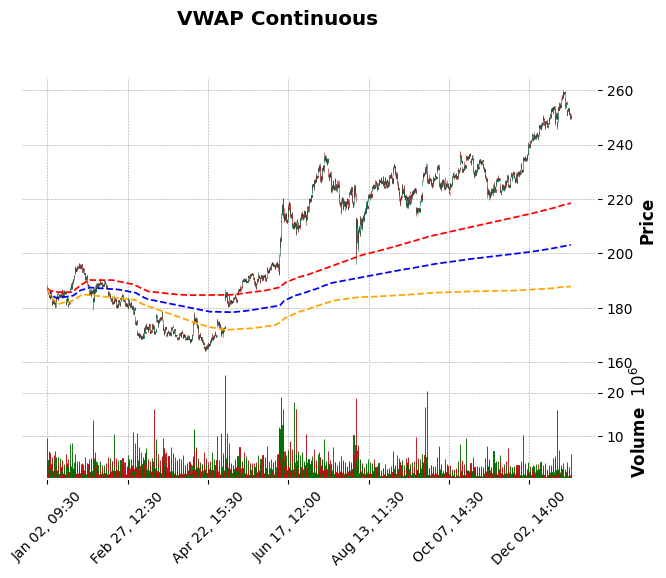

In [5]:
df_to_plot = df.copy()

df_to_plot['VWAP'] = (((df_to_plot['high'] + df_to_plot['low'] + df_to_plot['close']) / 3) * df_to_plot['volume']).cumsum() / df_to_plot['volume'].cumsum()

window_size = 100
std_multiplier = 2
df_to_plot['cumulative_std'] = [df_to_plot['VWAP'][:i+1].std() for i in range(len(df_to_plot))]
df_to_plot['Upper_Channel'] = df_to_plot['VWAP'] + (df_to_plot['cumulative_std']*std_multiplier)
df_to_plot['Lower_Channel'] = df_to_plot['VWAP'] - (df_to_plot['cumulative_std']*std_multiplier)

# plot_VWAP(df_to_plot, ['VWAP','Upper_Channel','Lower_Channel'])
plot_VWAP(df_to_plot, ['VWAP','Upper_Channel','Lower_Channel'], title="VWAP Continuous")

# VWAP with Daily Reset

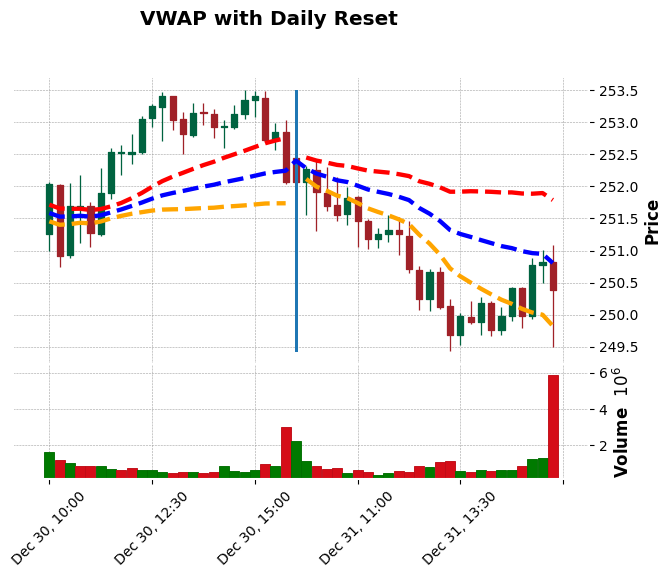

In [6]:
def calculate_daily_vwap(df):
    # Group by instrument and date
    def calculate_vwap(group):

        group['VWAP'] = (((group['high'] + group['low'] + group['close']) / 3) * group['volume']).cumsum() / group['volume'].cumsum()

        std_multiplier = 2
        # Calculate cumulative standard deviation for each row
        group['cumulative_std'] = [group['VWAP'][:i+1].std() for i in range(len(group))]
        group['Upper_Channel'] = group['VWAP'] + (group['cumulative_std']*std_multiplier)
        group['Lower_Channel'] = group['VWAP'] - (group['cumulative_std']*std_multiplier)

        return group

    # Apply VWAP calculation per date
    return df.groupby(df.index.to_series().dt.date, group_keys=False).apply(calculate_vwap)

df_to_plot = df.copy()
df_to_plot = calculate_daily_vwap(df_to_plot)
df_to_plot
plot_VWAP(df_to_plot.tail(50), ['VWAP','Upper_Channel','Lower_Channel'], title="VWAP with Daily Reset", day_change_vlines=True)

# Rolling VWAP

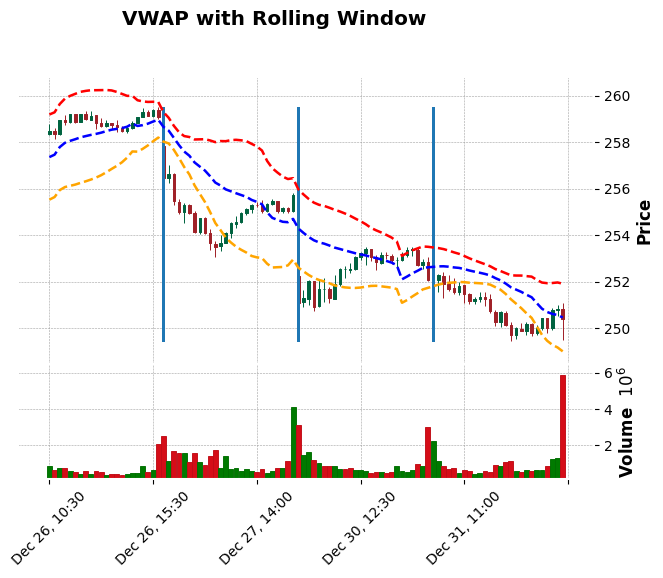

In [7]:
df_to_plot = df.copy()

# Define the rolling window size
rolling_window = 21
std_multiplier = 2

# Calculate the Rolling VWAP
df_to_plot['TPV'] = ((df_to_plot['high'] + df_to_plot['low'] + df_to_plot['close']) / 3) * df['volume']  # Typical Price Volume
df_to_plot['Rolling_TPV'] = df_to_plot['TPV'].rolling(window=rolling_window).sum()  # Rolling sum of TPV
df_to_plot['Rolling_Volume'] = df_to_plot['volume'].rolling(window=rolling_window).sum()  # Rolling sum of Volume
df_to_plot['VWAP'] = df_to_plot['Rolling_TPV'] / df_to_plot['Rolling_Volume']  # Rolling VWAP


df_to_plot['rolling_std'] = df_to_plot['VWAP'].rolling(window=rolling_window).std()
df_to_plot['Upper_Channel'] = df_to_plot['VWAP'] + (df_to_plot['rolling_std']*std_multiplier)
df_to_plot['Lower_Channel'] = df_to_plot['VWAP'] - (df_to_plot['rolling_std']*std_multiplier)


plot_VWAP(df_to_plot.tail(100), ['VWAP','Upper_Channel','Lower_Channel'], title="VWAP with Rolling Window", day_change_vlines=True)


# Moving VWAP

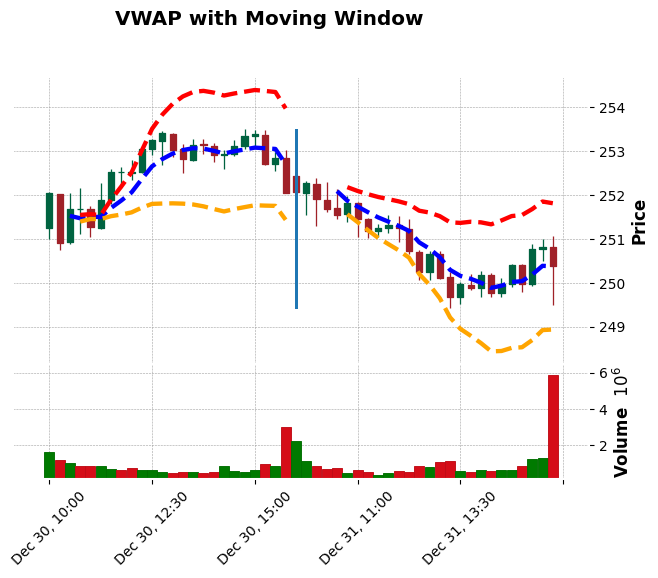

In [8]:
def calculate_daily_vwap(df):
    # Group by instrument and date
    def calculate_vwap(group):

        # Define the rolling window size
        rolling_window = 5

        # Calculate the Rolling VWAP
        group['TPV'] = ((group['high'] + group['low'] + group['close']) / 3) * group['volume']  # Typical Price Volume
        group['Rolling_TPV'] = group['TPV'].rolling(window=rolling_window).sum()  # Rolling sum of TPV
        group['Rolling_Volume'] = group['volume'].rolling(window=rolling_window).sum()  # Rolling sum of Volume
        group['VWAP'] = group['Rolling_TPV'] / group['Rolling_Volume']  # Rolling VWAP

        # group['VWAP'] = (((group['high'] + group['low'] + group['close']) / 3) * group['volume']).cumsum() / group['volume'].cumsum()

        std_multiplier = 2
        # Calculate cumulative standard deviation for each row
        group['cumulative_std'] = [group['VWAP'][:i+1].std() for i in range(len(group))]
        group['Upper_Channel'] = group['VWAP'] + (group['cumulative_std']*std_multiplier)
        group['Lower_Channel'] = group['VWAP'] - (group['cumulative_std']*std_multiplier)

        return group

    # Apply VWAP calculation per date
    return df.groupby(df.index.to_series().dt.date, group_keys=False).apply(calculate_vwap)

df_to_plot = df.copy()
df_to_plot = calculate_daily_vwap(df_to_plot)
df_to_plot
plot_VWAP(df_to_plot.tail(50), ['VWAP','Upper_Channel','Lower_Channel'], title="VWAP with Moving Window", day_change_vlines=True)

# Anchored VWAP

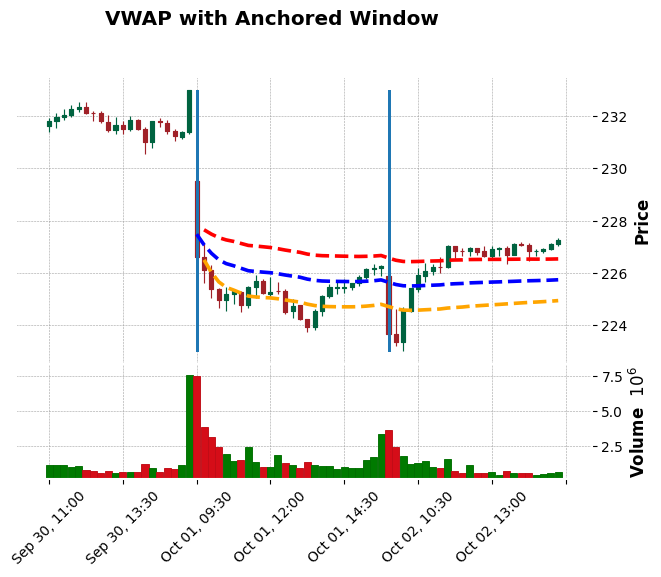

In [9]:
df_to_plot = df.copy()
anchor_date = pd.to_datetime('2024-10-01')

filtered_df = df_to_plot.loc[anchor_date:]
# Calculate VWAP for the filtered DataFrame
filtered_df['VWAP'] = (((filtered_df['high'] + filtered_df['low'] + filtered_df['close']) / 3) * filtered_df['volume']).cumsum() / filtered_df['volume'].cumsum()

std_multiplier = 2
# Calculate cumulative standard deviation for each row
filtered_df['cumulative_std'] = [filtered_df['VWAP'][:i+1].std() for i in range(len(filtered_df))]
filtered_df['Upper_Channel'] = filtered_df['VWAP'] + (filtered_df['cumulative_std']*std_multiplier)
filtered_df['Lower_Channel'] = filtered_df['VWAP'] - (filtered_df['cumulative_std']*std_multiplier)


df_to_plot.loc[filtered_df.index, 'VWAP'] = filtered_df['VWAP']
df_to_plot.loc[filtered_df.index, 'Upper_Channel'] = filtered_df['Upper_Channel']
df_to_plot.loc[filtered_df.index, 'Lower_Channel'] = filtered_df['Lower_Channel']

# Convert the index to a DatetimeIndex if it's not already
if not isinstance(df_to_plot.index, pd.DatetimeIndex):
    df_to_plot.index = pd.to_datetime(df_to_plot.index, errors='coerce')

df_to_plot.sort_index()

# Filter the data efficiently without using the removed `append()` method
filtered_df = pd.concat([
    df_to_plot[df_to_plot.index < anchor_date].tail(20),
    # df_to_plot.loc[:anchor_date].iloc[-10:],  # Last 10 rows before or at anchor_date
    df_to_plot[df_to_plot.index >= anchor_date].head(50)  # First 50 rows after anchor_date
])

plot_VWAP(filtered_df, ['VWAP','Upper_Channel','Lower_Channel'], title="VWAP with Anchored Window", day_change_vlines=True)


